<a href="https://colab.research.google.com/github/Hariom-99/License-plate-detection/blob/main/licensePlate.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [8]:
!pip install requests opencv-python


In [10]:
!pip install python-dotenv


In [11]:
# Create a .env file with your API key
with open(".env", "w") as f:
    f.write("PLATE_RECOGNIZER_KEY=59416f6f44c597e74744e6f439ca6688e42606a0\n")


Frame 0: Detected Plate: mw51vsu
Frame 0: Detected Plate: na13nru
Frame 0: Detected Plate: gx150gj


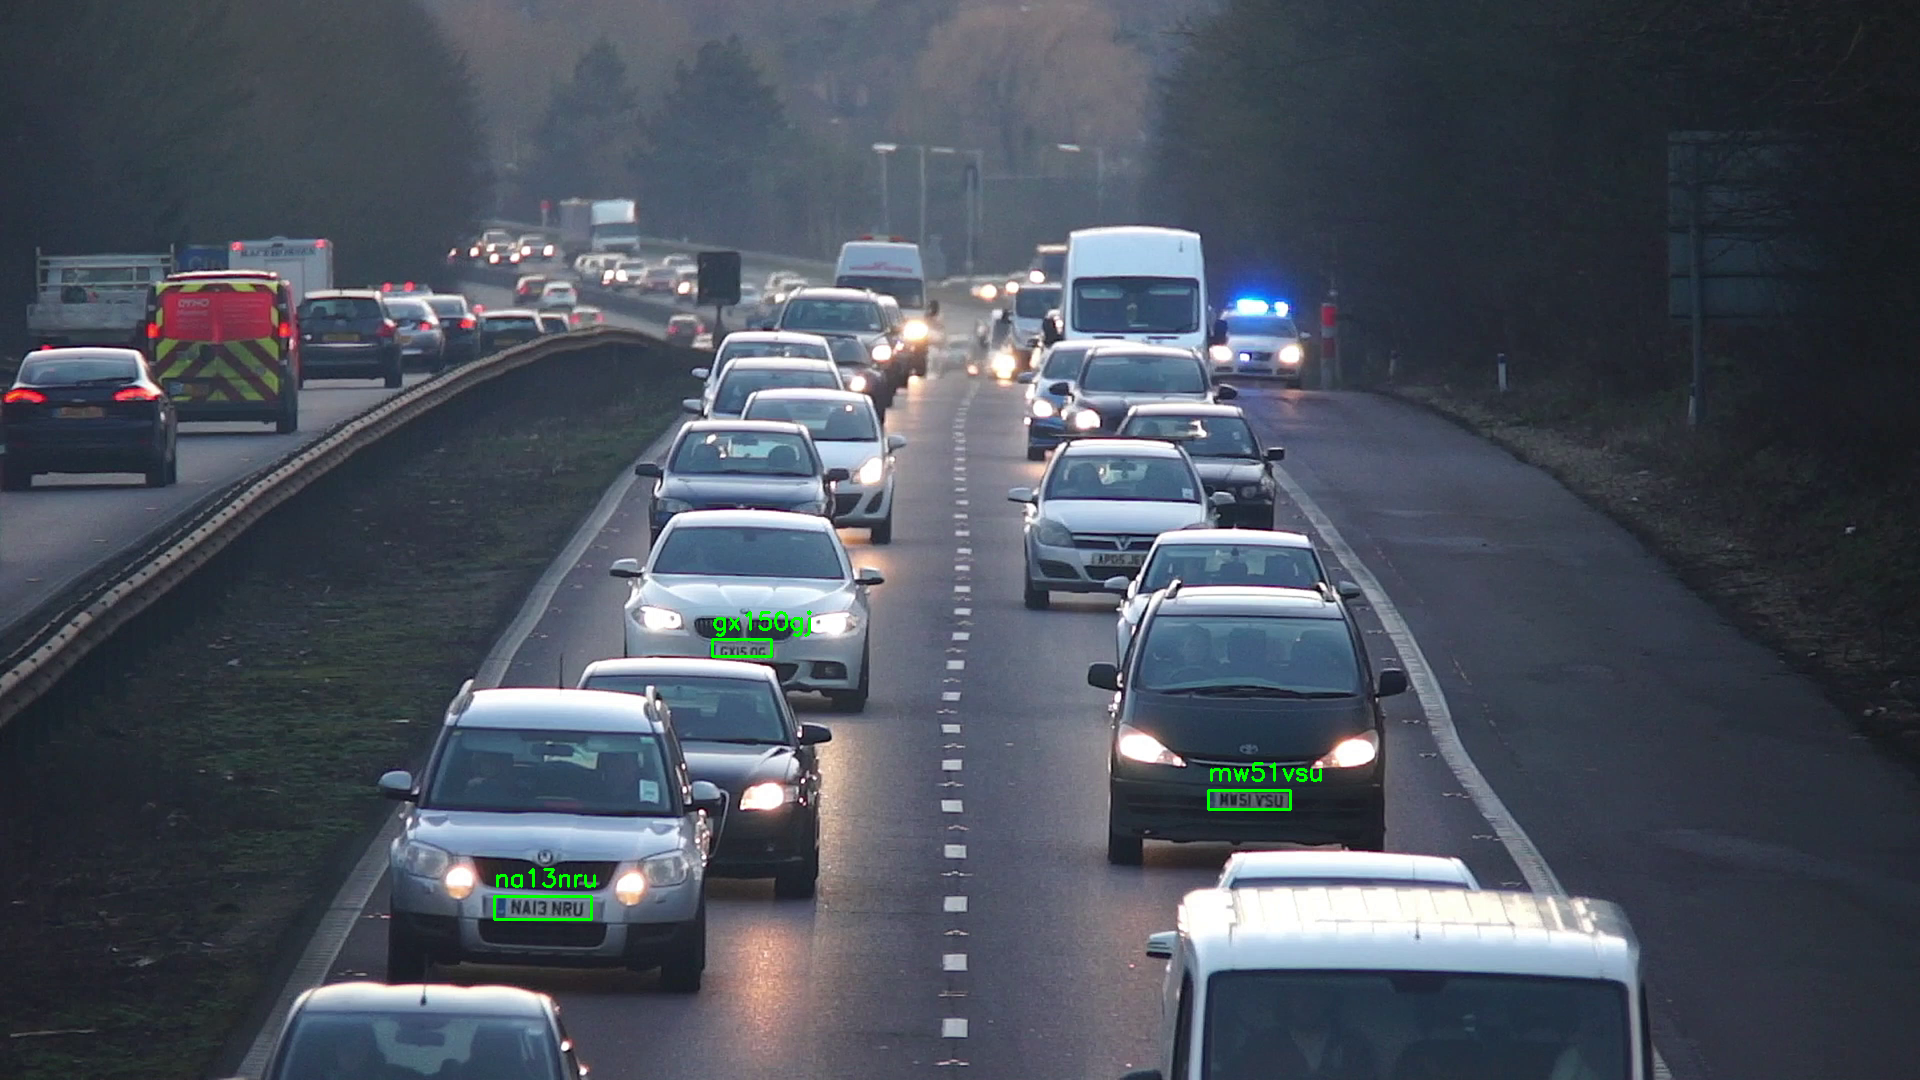

Frame 1: Detected Plate: mw51vsu
Frame 1: Detected Plate: na13nru
Frame 1: Detected Plate: gx150gj
Frame 2: Detected Plate: mw51vsu
Frame 2: Detected Plate: na13nru
Frame 2: Detected Plate: gx15ogj
Frame 3: Detected Plate: mw51vsu
Frame 3: Detected Plate: na13nru
Frame 3: Detected Plate: gx15ogj
Frame 4: Detected Plate: mw51vsu
Frame 4: Detected Plate: na13nru
Frame 4: Detected Plate: gx15ogj
Frame 4: Detected Plate: ap05j6
Frame 5: Detected Plate: mw51vsu
Frame 5: Detected Plate: na13nru
Frame 5: Detected Plate: gx15qgj
Frame 6: Detected Plate: mw51vsu
Frame 6: Detected Plate: na13nru
Frame 6: Detected Plate: gx15ogj


KeyboardInterrupt: 

In [12]:
import cv2
import requests
from google.colab.patches import cv2_imshow
from google.colab import userdata

# Retrieve the secret value
API_KEY = userdata.get('PLATE_RECOGNIZER_KEY')


# ====== 1. Set your API key ======
API_URL = "https://api.platerecognizer.com/v1/plate-reader/"

# ====== 2. Path to your uploaded video ======
video_path = "/content/Untitled video - Made with Clipchamp.mp4"  # replace with actual file name

# ====== 3. Open video ======
cap = cv2.VideoCapture(video_path)
width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
fps = cap.get(cv2.CAP_PROP_FPS)

# Output video writer
fourcc = cv2.VideoWriter_fourcc(*'mp4v')
out = cv2.VideoWriter("plate_output_video.mp4", fourcc, fps, (width, height))

frame_count = 0

while True:
    ret, frame = cap.read()
    if not ret:
        break

    # ====== Save temporary frame ======
    temp_frame_path = f"temp_frame.jpg"
    cv2.imwrite(temp_frame_path, frame)

    # ====== Send frame to Plate Recognizer API ======
    with open(temp_frame_path, "rb") as f:
        response = requests.post(
            API_URL,
            files={"upload": f},
            headers={"Authorization": f"Token {API_KEY}"}
        )

    # ====== Parse API response ======
    data = response.json()
    for plate in data.get('results', []):
        bbox = plate['box']
        text = plate['plate']
        x1, y1, x2, y2 = bbox['xmin'], bbox['ymin'], bbox['xmax'], bbox['ymax']

        # Draw bounding box and plate text
        cv2.rectangle(frame, (x1, y1), (x2, y2), (0,255,0), 2)
        cv2.putText(frame, text, (x1, y1-10),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.8, (0,255,0), 2)
        print(f"Frame {frame_count}: Detected Plate: {text}")

    # Optional: preview every 30th frame
    if frame_count % 30 == 0:
        cv2_imshow(frame)

    # Write frame to output video
    out.write(frame)
    frame_count += 1

# ====== Release resources ======
cap.release()
out.release()
print("✅ Processing complete! Saved as plate_output_video.mp4")
